In [3]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Data preparation (same as your code)
image_size = 128
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes

# CNN builder function with parameters to optimize
def build_model(learning_rate, dropout_rate, dense_units):
    model = Sequential([
        tf.keras.Input(shape=(image_size, image_size, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Ant Lion Optimization Parameters
num_ants = 3
iterations = 3

# Define search space for hyperparameters
search_space = {
    'learning_rate': [0.0005, 0.001, 0.002],
    'dropout': [0.3, 0.4, 0.5],
    'dense_units': [32, 64, 128]
}

# Initialize ants randomly within search space
ants = []
for _ in range(num_ants):
    ant = {
        'learning_rate': random.choice(search_space['learning_rate']),
        'dropout': random.choice(search_space['dropout']),
        'dense_units': random.choice(search_space['dense_units'])
    }
    ants.append(ant)

best_ant = None
best_val_acc = 0

# Simplified ALO search (random walk + selection)
for iter in range(iterations):
    print(f"\n--- ALO Iteration {iter+1}/{iterations} ---")
    for i, ant in enumerate(ants):
        print(f" Ant {i+1} Params: {ant}")
        model = build_model(ant['learning_rate'], ant['dropout'], ant['dense_units'])
        model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=0)
        _, val_acc = model.evaluate(val_generator, verbose=0)

        print(f"  → Validation Accuracy: {val_acc:.4f}")

        # Update best if current ant better
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_ant = ant
            best_model = model

    # Ants move to new random positions (random walk around best ant)
    for ant in ants:
        ant['learning_rate'] = random.choice(search_space['learning_rate'])
        ant['dropout'] = random.choice(search_space['dropout'])
        ant['dense_units'] = random.choice(search_space['dense_units'])

# Final evaluation on test set
print(f"\n✅ Best ALO Hyperparameters: {best_ant}")
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\n🎯 Final Test Accuracy (ALO Optimized): {test_acc:.2%}")


Found 2240 images belonging to 5 classes.
Found 480 images belonging to 5 classes.
Found 480 images belonging to 5 classes.

--- ALO Iteration 1/3 ---
 Ant 1 Params: {'learning_rate': 0.001, 'dropout': 0.3, 'dense_units': 32}
  → Validation Accuracy: 0.9937
 Ant 2 Params: {'learning_rate': 0.001, 'dropout': 0.3, 'dense_units': 64}
  → Validation Accuracy: 0.9937
 Ant 3 Params: {'learning_rate': 0.002, 'dropout': 0.5, 'dense_units': 64}
  → Validation Accuracy: 0.9896

--- ALO Iteration 2/3 ---
 Ant 1 Params: {'learning_rate': 0.001, 'dropout': 0.3, 'dense_units': 128}
  → Validation Accuracy: 0.9729
 Ant 2 Params: {'learning_rate': 0.001, 'dropout': 0.4, 'dense_units': 32}
  → Validation Accuracy: 0.9896
 Ant 3 Params: {'learning_rate': 0.0005, 'dropout': 0.3, 'dense_units': 128}
  → Validation Accuracy: 0.9958

--- ALO Iteration 3/3 ---
 Ant 1 Params: {'learning_rate': 0.0005, 'dropout': 0.3, 'dense_units': 32}
  → Validation Accuracy: 0.7937
 Ant 2 Params: {'learning_rate': 0.002, 'd

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Confusion Matrix:
[[96  0  0  0  0]
 [ 0 96  0  0  0]
 [ 0  0 96  0  0]
 [ 3  0  0 93  0]
 [ 0  0  0  0 96]]


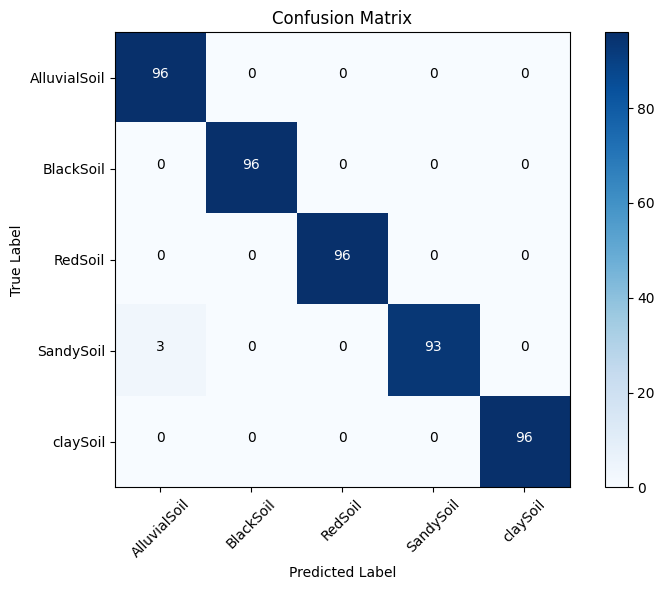


Classification Report:
              precision    recall  f1-score   support

AlluvialSoil       0.97      1.00      0.98        96
   BlackSoil       1.00      1.00      1.00        96
     RedSoil       1.00      1.00      1.00        96
   SandySoil       1.00      0.97      0.98        96
    claySoil       1.00      1.00      1.00        96

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



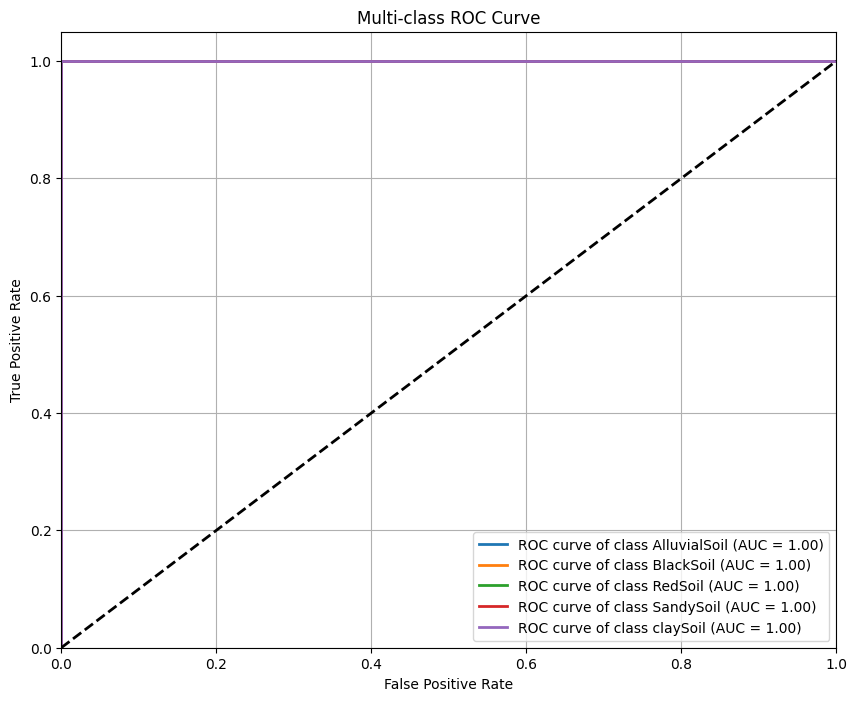

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Make sure test_generator is reset before predictions
test_generator.reset()

# True labels (integers)
y_true = test_generator.classes

# Predicted probabilities from best WOA-optimized model
y_pred_prob = best_model.predict(test_generator, verbose=1)

# Predicted class labels (argmax of predicted probabilities)
y_pred = np.argmax(y_pred_prob, axis=1)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# 3. ROC Curve and AUC for multi-class
# Binarize true labels for ROC curve (one-hot style)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i, class_label in enumerate(test_generator.class_indices.keys()):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_label} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
